In [2]:
import numpy as np 
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertForSequenceClassification
import warnings
warnings.filterwarnings("ignore")

2024-02-21 03:04:58.538447: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
df = pd.read_csv('yahoo.csv')
df.head()

,Unnamed: 0,ticker,Date,category,title,content,Open,High,Low,Close,Adj Close,Volume,label
0,0,AAPL,2020-01-27,opinion,Apple Set To Beat Q1 Earnings Estimates Tech ...,Technology giant Apple NASDAQ AAPL is set ...,77.514999,77.942497,76.220001,77.237503,75.793358,161940000,0
1,1,AAPL,2020-01-27,opinion,Tech Daily Intel Results Netflix Surge Appl...,The top stories in this digest are Intel s N...,77.514999,77.942497,76.220001,77.237503,75.793358,161940000,0
2,2,AAPL,2020-01-27,opinion,7 Monster Stock Market Predictions For The Wee...,S P 500 SPY \nThis week will be packed with e...,77.514999,77.942497,76.220001,77.237503,75.793358,161940000,0
3,3,AAPL,2020-01-27,opinion,Apple Earnings Preview 5G Launch Expanding S...,Reports Q1 2020 results on Tuesday Jan 28 ...,77.514999,77.942497,76.220001,77.237503,75.793358,161940000,0
4,4,AAPL,2020-01-27,opinion,Buy Surging Apple Microsoft Stock Before Qua...,On today s episode of Full Court Finance here ...,77.514999,77.942497,76.220001,77.237503,75.793358,161940000,0


In [15]:
X = df['content'].to_list()
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model_finbert = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [16]:
preds = []
preds_proba = []
tokenizer_kwargs = {"padding": True, "truncation": True, "max_length": 512}
for x in X:
    with torch.no_grad():
        input_sequence = tokenizer(x, return_tensors="pt", **tokenizer_kwargs)
        logits = model_finbert(**input_sequence).logits
        scores = {
        k: v
        for k, v in zip(
            model_finbert.config.id2label.values(),
            scipy.special.softmax(logits.numpy().squeeze()),
        )
    }
    sentimentFinbert = max(scores, key=scores.get)
    probabilityFinbert = max(scores.values())
    preds.append(sentimentFinbert)
    preds_proba.append(probabilityFinbert)

In [71]:
df['predicted_finbert'] = preds

<Axes: xlabel='predicted_finbert'>

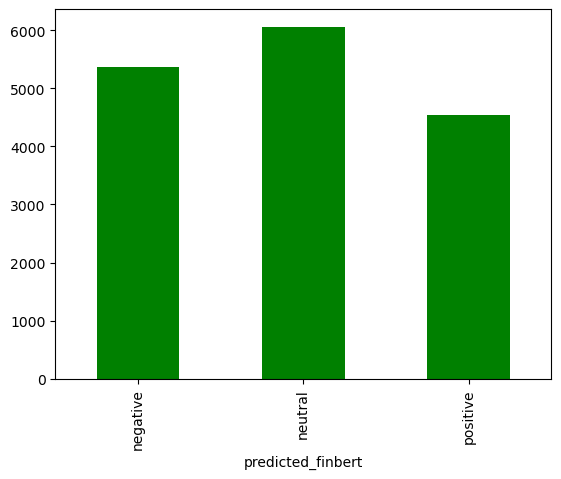

In [18]:
df.groupby('predicted_finbert').count().plot(kind='bar',color = 'green', legend = None)

In [19]:
df.to_csv('data_with_finbert.csv')

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from tensorflow.keras import regularizers
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [6]:
def createDataset(dataset, target, lookBack=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - lookBack):
        a = dataset[i:(i + lookBack), :]
        dataX.append(a)
        dataY.append(target[i + lookBack])
    return np.array(dataX), np.array(dataY)

In [25]:
df_feature = pd.read_csv('final_data.csv', encoding='unicode_escape')
df_new_feature = df_feature.drop(df_feature.columns[[0, 2,3, 4, 5]], axis=1)

In [26]:
features = df_new_feature.drop(['Date', 'Close'], axis=1).values
target = df_new_feature['Close'].values

In [142]:
scalerFeatures = MinMaxScaler(feature_range=(0, 1))
scalerTarget = MinMaxScaler(feature_range=(0, 1))

featuresScaled = scalerFeatures.fit_transform(features)
targetScaled = scalerTarget.fit_transform(target.reshape(-1, 1))

lookBack = 1
X, y = createDataset(featuresScaled, targetScaled, lookBack)
print(X[:2])
print(y[:2])

trainSize = int(len(X) * 0.8)
testSize = len(X) - trainSize
trainX, testX = X[0:trainSize, :], X[trainSize:len(X), :]
trainY, testY = y[0:trainSize], y[trainSize:len(y)]

trainX = np.reshape(trainX, (trainX.shape[0], lookBack, trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], lookBack, testX.shape[2]))

[[[0.11135626 0.11069319 0.11026156 0.0955537  0.312651   0.02665286
   0.43235819 0.56542468]]

 [[0.11135626 0.11069319 0.11026156 0.0955537  0.312651   0.02665286
   0.43235819 0.56542468]]]
[[0.11566743]
 [0.11566743]]


In [143]:
batchSize = 1
epoch = 20
neurons = 100
dropout = 0.6

model = Sequential()
model.add(LSTM(neurons, return_sequences=True, activation='tanh', input_shape=(lookBack, features.shape[1])))
model.add(Dropout(dropout))
model.add(LSTM(neurons, return_sequences=True, activation='tanh'))
model.add(Dropout(dropout))
model.add(LSTM(neurons, activation='tanh'))
model.add(Dropout(dropout))

model.add(Dense(units=1, activation='linear', activity_regularizer=regularizers.l1(0.00001)))
model.add(Activation('tanh'))
model.summary()

model.compile(loss='mean_squared_error' , optimizer='RMSprop')

model.fit(trainX, trainY, epochs=epoch, batch_size=batchSize, verbose=1, validation_split=0.2)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 1, 100)            43600     
                                                                 
 dropout_12 (Dropout)        (None, 1, 100)            0         
                                                                 
 lstm_13 (LSTM)              (None, 1, 100)            80400     
                                                                 
 dropout_13 (Dropout)        (None, 1, 100)            0         
                                                                 
 lstm_14 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_14 (Dropout)        (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                

In [144]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredictInv = scalerTarget.inverse_transform(trainPredict)
trainYInv = scalerTarget.inverse_transform(np.reshape(trainY, (trainY.shape[0], 1)))
testPredictInv = scalerTarget.inverse_transform(testPredict)
testYInv = scalerTarget.inverse_transform(np.reshape(testY, (testY.shape[0], 1)))

100/100 [==============================] - 0s 2ms/step


In [145]:
trainScore = np.sqrt(mean_squared_error(trainYInv[:, 0], trainPredictInv[:, 0]))
print(f'Training RMSE: {trainScore}')
testScore = np.sqrt(mean_squared_error(testYInv[:, 0], testPredictInv[:, 0]))
print(f'Testing RMSE: {testScore}')

trainAccuracy = 100 - (trainScore / np.mean(trainYInv) * 100)
testAccuracy = 100 - (testScore / np.mean(testYInv) * 100)

print(f'Training Accuracy: {trainAccuracy:.2f}%')
print(f'Testing Accuracy: {testAccuracy:.2f}%')

Training RMSE: 1.9240574381923738
Testing RMSE: 10.305971898584904
Training Accuracy: 94.79%
Testing Accuracy: 81.38%


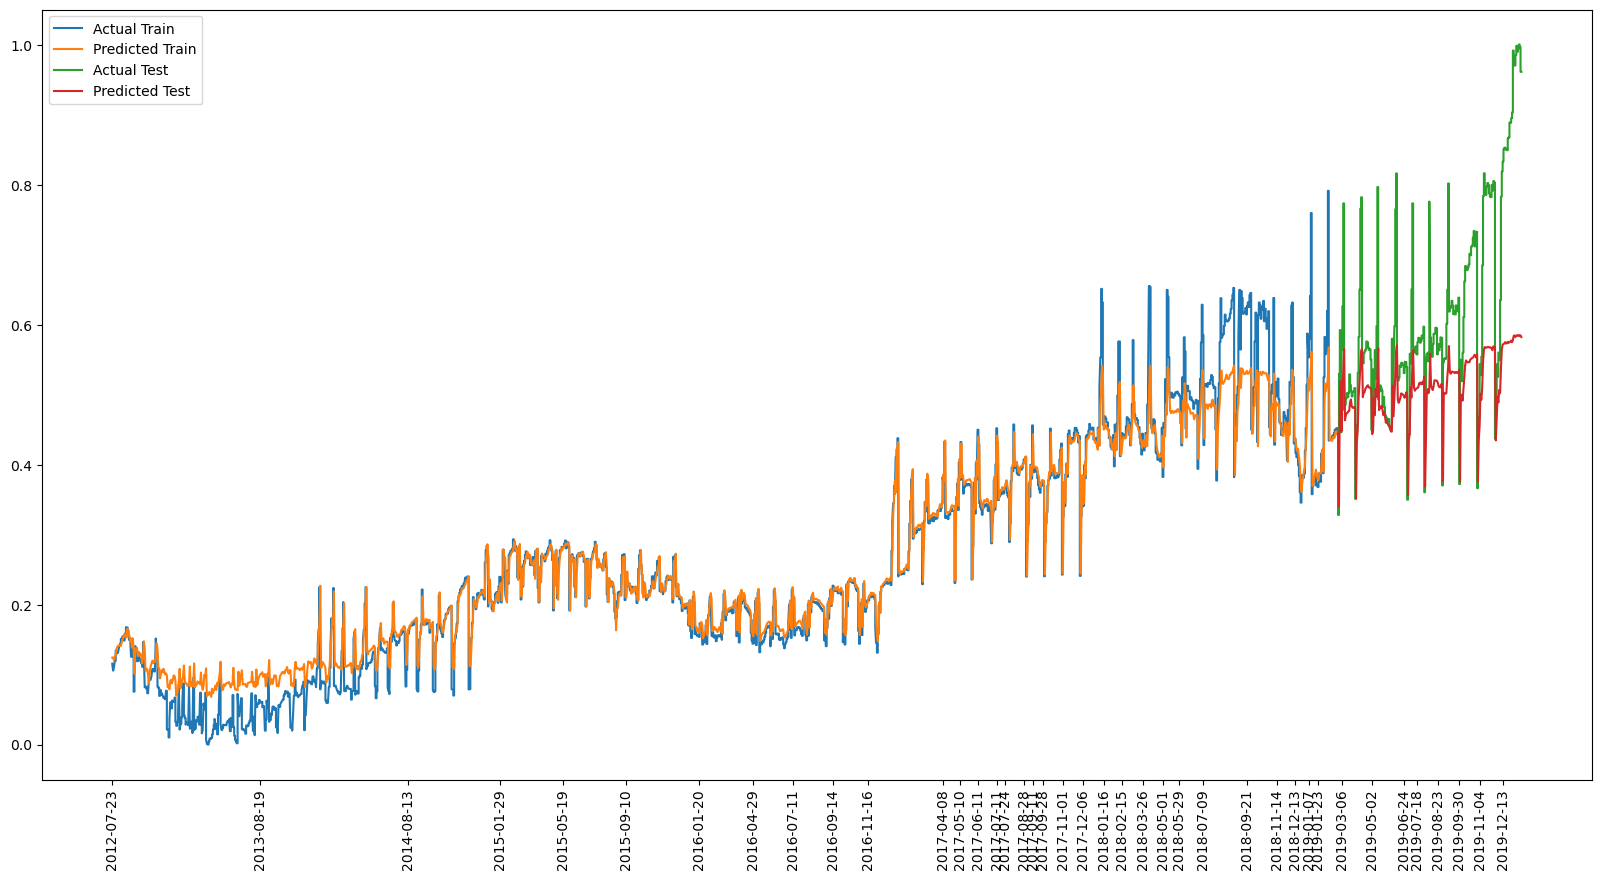

In [146]:
dates = df_new_feature['Date'].values
sampledDates = dates[::400]

plt.figure(figsize=(20, 10))
plt.plot(dates[:len(trainY)], trainY, label='Actual Train')
plt.plot(dates[:len(trainPredict)], trainPredict, label='Predicted Train')
plt.plot(dates[len(trainY):len(trainY) + len(testY)], testY, label='Actual Test')
plt.plot(dates[len(trainPredict):len(trainPredict) + len(testPredict)], testPredict, label='Predicted Test')

plt.xticks(sampledDates, rotation=90)

plt.legend()
plt.show()

In [80]:
df_corr = df_new_feature.drop(df_new_feature.columns[[0, 1, 2,3, 5, 6]], axis=1)
df_corr.head()

,Close,pos,neg,neu
0,21.565357,0.033079,0.424412,0.542509
1,21.565357,0.033079,0.424412,0.542509
2,21.565357,0.033079,0.424412,0.542509
3,21.461430,0.031984,0.038037,0.929979
4,20.898571,0.040444,0.418283,0.541273


In [108]:
df_corr.corr(method='pearson')

,Close,pos,neg,neu
Close,1.000000,0.181796,-0.104287,-0.047008
pos,0.181796,1.000000,-0.448193,-0.387922
neg,-0.104287,-0.448193,1.000000,-0.650071
neu,-0.047008,-0.387922,-0.650071,1.000000


In [100]:
final_df = df_new_feature.drop(df_new_feature.columns[[0]], axis=1)
final_df.head()

,Open,High,Low,Close,Adj Close,Volume,pos,neg,neu
0,21.228571,21.639286,20.989643,21.565357,18.413187,487975600,0.033079,0.424412,0.542509
1,21.228571,21.639286,20.989643,21.565357,18.413187,487975600,0.033079,0.424412,0.542509
2,21.228571,21.639286,20.989643,21.565357,18.413187,487975600,0.033079,0.424412,0.542509
3,21.692142,21.774286,21.375357,21.461430,18.324455,565132400,0.031984,0.038037,0.929979
4,20.536072,20.922501,20.413929,20.898571,17.843870,403936400,0.040444,0.418283,0.541273


In [169]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 
  
# new_vif_data = pd.DataFrame() 
# new_vif_data["feature"] = df_corr.columns 

# new_vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
#                           for i in range(len(X.columns))] 
  
print(new_vif_data)

  feature       VIF
1     pos  5.676505
2     neg  3.202645
3     neu  7.354345


In [176]:
metric = tf.keras.metrics.R2Score()

In [177]:
metric.update_state(trainY, trainPredict)

In [178]:
result = metric.result()

In [179]:
result.numpy()

0.9565251